In [1]:
# install dependencies
!pip install deepcell==0.10.1 torch torchvision transformers

     |████████████████████████████████| 139 kB 23.2 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
     |████████████████████████████████| 887.5 MB 16 kB/s              
     |████████████████████████████████| 24.2 MB 75.1 MB/s            
     |████████████████████████████████| 7.2 MB 61.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 123 kB 63.4 MB/s            
     |████████████████████████████████| 679 kB 52.1 MB/s            
     |████████████████████████████████| 40 kB 9.1 MB/s             
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
     |████████████████████████████████| 460.3 MB 16 kB/s              
     |████████████████████████████████| 49.1 MB 60.6 MB/s            
  Using cached numpy-1.19.5-cp37-cp37m-manylinux201

In [203]:
import os
import torch
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.measure import regionprops
from skimage.exposure import rescale_intensity
from transformers import SamModel, SamProcessor, SamVisionConfig, SamConfig
from deepcell_toolbox.metrics import PixelMetrics
from deepcell.applications import Mesmer

# Get data

In [231]:
stardist = np.load('/sbgenomics/project-files/stardist2d_results_val.npz') #path to StarDist masks
cellpose = np.load('/sbgenomics/project-files/cellposeall_results_val.npz') #path to Cellpose masks

In [250]:
stardist_y = stardist['stardist2d_prediction'] #StarDist
cellpose_y = cellpose['cyto2_prediction'] #Cellpose
gt = cellpose['ground_truth'] #ground truth
images = stardist['images']#TissueNet images

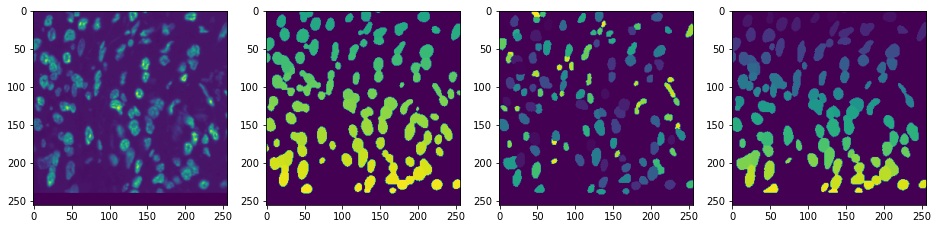

In [237]:
#confirmation
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(images[110].squeeze())
ax[1].imshow(gt[110].squeeze())
ax[2].imshow(stardist_y[110].squeeze())
ax[3].imshow(cellpose_y[110].squeeze())
fig.show()

In [251]:
#choose TissueNet eval images/masks
sd = stardist_y[100:110].squeeze().copy() #StarDist
cp = cellpose_y[100:110].squeeze().copy() #Cellpose
imgs = images[100:110].squeeze().copy() #TissueNet images
gts = gt[100:110].squeeze().copy() #Ground truth masks

In [240]:
#run Mesmer
mimgs = np.stack([imgs,imgs],axis=3) #stack images for 2 channel requirement
mesmer_model = Mesmer() #instantiate model
mesmer_y = mesmer_model.predict(mimgs, compartment='nuclear', batch_size=100) #run inference

#Mesmer masks
mm = mesmer_y.squeeze().copy()

# Run SAM with each segmentation method

In [253]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [254]:
def run_sam_with_masks(images, y_pred, bbox_prompt=True, points_prompt=True):
    final_masks = []
    for i in tqdm(range(images.shape[0])):
        #get prompts from ground truth mask
        centroids = np.array([rp.centroid for rp in regionprops(y_pred[i,:,:])])
        bbox = np.array([rp.bbox for rp in regionprops(y_pred[i,:,:])])

        #pre-process input image
        nuc_channel = rescale_intensity(images[i,:,:], 
                                        in_range=(np.percentile(images[i,:,:],1),np.percentile(x,99)),
                                        out_range='uint8')
        input_im = np.stack([nuc_channel,nuc_channel,nuc_channel], axis=2)
        input_im = np.expand_dims(input_im, axis=0) 
        inputs = processor(input_im, return_tensors="pt").to("cuda") 

        #embed image with SAM image encoder
        with torch.no_grad():
            image_embed = model.get_image_embeddings(inputs['pixel_values'])

        #get generated mask for each prompt
        masks, scores = [], []
        for box,centroid in zip(bbox, centroids):
            #format point prompt
            point_prompt = np.expand_dims(list(reversed(centroid)), [0,1,2]).tolist()
            #format bbox prompt
            y0, x0, y1, x1 = box
            box_prompt = np.expand_dims([x0, y0, x1, y1], [0,1]).tolist()
            #run prompts through pre-processor to properly resize prompts
            if (bbox_prompt==True) and (points_prompt==True):
                inputs = processor(input_im, input_boxes=box_prompt, input_points=point_prompt, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(image_embeddings=image_embed, input_points=inputs.input_points.to('cuda:0'), input_boxes=inputs.input_boxes.to("cuda:0"))
            elif (bbox_prompt==True) and (points_prompt==False):
                inputs = processor(input_im, input_boxes=box_prompt, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(image_embeddings=image_embed, input_boxes=inputs.input_boxes.to('cuda:0'))
            elif (bbox_prompt==False) and (points_prompt==True):
                inputs = processor(input_im, input_points=point_prompt, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(image_embeddings=image_embed, input_points=inputs.input_points.to('cuda:0'))
            else:
                inputs = processor(input_im, return_tensors="pt")
            #forward pass through mask decoder
            #with torch.no_grad():
            #    outputs = model(image_embeddings=image_embed, input_ponts=inputs.input_points.to("cuda:0"), input_boxes=inputs.input_boxes.to("cuda:0"))
            #post-process masks to get back to original input size
            masks_ = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
                                                                  inputs["original_sizes"].cpu(), 
                                                                  inputs["reshaped_input_sizes"].cpu())
            scores_ = outputs.iou_scores
            masks.append(masks_)
            scores.append(scores_)


        #merge masks 
        final_mask = np.zeros((256,256))
        for i, (mask,score) in enumerate(zip(masks,scores)):
            best_mask_idx = torch.argmax(score)
            top_mask = mask[0][0][best_mask_idx].cpu().numpy().astype('int')
            top_mask *= (i + 1)
            cell_id = i + 1
            final_mask[(final_mask == 0) & (top_mask == cell_id)] = cell_id

        final_masks.append(final_mask)
    
    return np.stack(final_masks, axis=0)

In [ ]:
#Cellpose
cp_results = []

# baseline
metrics = PixelMetrics(np.expand_dims(cp,3), np.expand_dims(gts,3))
cp_results.append(metrics.f1)

# SAM + Cellpose (no points)
sam_plus_cellpose = run_sam_with_masks(imgs, cp, bbox_prompt=True, points_prompt=False)
metrics = PixelMetrics(np.expand_dims(sam_plus_cellpose,3), np.expand_dims(gts,3))
cp_results.append(metrics.f1)

# SAM + Cellpose (no boxes)
sam_plus_cellpose = run_sam_with_masks(imgs, cp, bbox_prompt=False, points_prompt=True)
metrics = PixelMetrics(np.expand_dims(sam_plus_cellpose,3), np.expand_dims(gts,3))
cp_results.append(metrics.f1)

# SAM + Cellpose (boxes and points)
sam_plus_cellpose = run_sam_with_masks(imgs, cp, bbox_prompt=True, points_prompt=True)
metrics = PixelMetrics(np.expand_dims(sam_plus_cellpose,3), np.expand_dims(gts,3))
cp_results.append(metrics.f1)

 60%|██████    | 12/20 [01:13<01:03,  7.94s/it]

In [ ]:
#StarDist
sd_results = []

# baseline
metrics = PixelMetrics(np.expand_dims(sd,3), np.expand_dims(gts,3))
sd_results.append(metrics.f1)

# SAM + StarDist (no points)
sam_plus_stardist = run_sam_with_masks(imgs, sd, bbox_prompt=True, points_prompt=False)
metrics = PixelMetrics(np.expand_dims(sam_plus_stardist,3), np.expand_dims(gts,3))
sd_results.append(metrics.f1)

# SAM + StarDist (no boxes)
sam_plus_stardist = run_sam_with_masks(imgs, sd, bbox_prompt=False, points_prompt=True)
metrics = PixelMetrics(np.expand_dims(sam_plus_stardist,3), np.expand_dims(gts,3))
sd_results.append(metrics.f1)

# SAM + StarDist (boxes and points)
sam_plus_stardist = run_sam_with_masks(imgs, sd, bbox_prompt=True, points_prompt=True)
metrics = PixelMetrics(np.expand_dims(sam_plus_stardist,3), np.expand_dims(gts,3))
sd_results.append(metrics.f1)

In [ ]:
#Mesmer
mm_results = []

# baseline
metrics = PixelMetrics(np.expand_dims(mm,3), np.expand_dims(gts,3))
mm_results.append(metrics.f1)

# SAM + Mesmer (no points)
sam_plus_mesmer = run_sam_with_masks(imgs, mm, bbox_prompt=True, points_prompt=False)
metrics = PixelMetrics(np.expand_dims(sam_plus_mesmer,3), np.expand_dims(gts,3))
mm_results.append(metrics.f1)

# SAM + Mesmer (no boxes)
sam_plus_mesmer = run_sam_with_masks(imgs, mm, bbox_prompt=False, points_prompt=True)
metrics = PixelMetrics(np.expand_dims(sam_plus_mesmer,3), np.expand_dims(gts,3))
mm_results.append(metrics.f1)

# SAM + Mesmer (boxes + points)
sam_plus_mesmer = run_sam_with_masks(imgs, mm, bbox_prompt=True, points_prompt=True)
metrics = PixelMetrics(np.expand_dims(sam_plus_mesmer,3), np.expand_dims(gts,3))
mm_results.append(metrics.f1)

In [183]:
#save results
results = np.array([sd_results, cp_results, mm_results])
key = ['base','just boxes', 'just points', 'points + boxes']
results_dict = {'StarDist':sd_results,'Cellpose':cp_results,'Mesmer':mm_results,'key':key}

In [205]:
with open('/sbgenomics/output-files/heussner_results.pkl','wb') as handle:
    pickle.dump(results_dict,handle)

In [211]:
#load saved results
with open('/sbgenomics/output-files/heussner_results.pkl','rb') as handle:
    res = pickle.load(handle)
results = np.array([res['StarDist'], res['Cellpose'], res['Mesmer']])

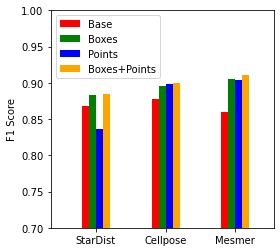

In [216]:
#comparison figure
xs = [0,1,2]
plt.figure(figsize=(4,4))
plt.bar(xs, results[:,0],width = 0.1,color='red',label='Base')
xs = [x+0.1 for x in xs]
plt.bar(xs, results[:,1],width = 0.1,color='green',label='Boxes')
xs = [x+0.1 for x in xs]
plt.bar(xs, results[:,2],width = 0.1,color='blue',label='Points')
xs = [x+0.1 for x in xs]
plt.bar(xs, results[:,3],width = 0.1,color='orange',label='Boxes+Points')
plt.xticks([0.15,1.15,2.15],['StarDist','Cellpose','Mesmer'])
plt.ylabel('F1 Score')
plt.legend()
plt.ylim([0.7,1])
plt.xlim([-0.5,2.7])
plt.savefig('/sbgenomics/output-files/seg_comparison.png',dpi=900)
plt.show()